In [343]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})
import folium
from folium.plugins import MarkerCluster
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import multiprocessing
from sklearn.feature_selection import RFECV
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split


%matplotlib inline

In [2]:
def extract_loc_num(loc_string):
    return float(loc_string.split(' ')[1])

train = pd.read_csv('./data/train.csv', converters = {'location':extract_loc_num}, dtype = {'fault_severity':int})
train.name = 'train_df'
test = pd.read_csv('./data/test.csv', converters = {'location':extract_loc_num},  dtype = {'fault_severity':int})
test.name = 'test_df'
#  index_col='id'
severity = pd.read_csv('./data/severity_type.csv', converters = {'severity_type':extract_loc_num})
severity.name = 'severity_df'

events = pd.read_csv('./data/event_type.csv', converters = {'event_type':extract_loc_num})
events.name = 'events_df'
log = pd.read_csv('./data/log_feature.csv', converters = {'log_feature':extract_loc_num})
log.name = 'log_df'
resource = pd.read_csv('./data/resource_type.csv', converters = {'resource_type':extract_loc_num})
resource.name = 'resource_df'

Number of BSs of each operator

In [3]:
bs = pd.read_csv('./data/SITEFINDER_MAY_2012.csv', dtype={'Opref': str, 'Sitelat': float, 'Sitelng': float})

print(bs['Operator'].value_counts(), end="\n\n")

# Sample Orange opertor BSs
# bs = bs[(bs['Operator'] == 'Orange') & ~(bs['Anttype'].isin(['Pico']))].sample(frac=.15, random_state=2)
bs = bs[(bs['Operator'] == 'Orange')]
bs.name = 'uk_bs'
print('Number of Orange BSs accross UK: {}'.format(bs.shape[0]))

Vodafone        45760
T-Mobile        36183
O2              24592
Orange          19981
Three           13225
Airwave          3466
Network Rail     1104
Name: Operator, dtype: int64

Number of Orange BSs accross UK: 19981


In [4]:
dfs = [train, test, events, log, resource, severity, bs]
for i, df in enumerate(dfs):
    print(df.name)
    print(df.shape[0])
    print(df.head(2))
    print('\n')

train_df
7381
      id  location  fault_severity
0  14121     118.0               1
1   9320      91.0               0


test_df
11171
      id  location
0  11066     481.0
1  18000     962.0


events_df
31170
     id  event_type
0  6597        11.0
1  8011        15.0


log_df
58671
     id  log_feature  volume
0  6597         68.0       6
1  8011         68.0       7


resource_df
21076
     id  resource_type
0  6597            8.0
1  8011            8.0


severity_df
18552
     id  severity_type
0  6597            2.0
1  8011            2.0


uk_bs
19981
      Operator    Opref       Sitengr  Antennaht Transtype  Freqband Anttype  \
29162   Orange  ANT0002  IJ2434767257       15.0       GSM      1800  SECTOR   
29163   Orange  ANT0002  IJ2434767257       15.0      UMTS      2100  SECTOR   

       Powerdbw  Maxpwrdbw  Maxpwrdbm   Sitelat  Sitelng  
29162      30.9       32.0        NaN  54.53838  -6.0796  
29163      29.4        NaN       65.0  54.53838  -6.0796  




Mean and std of BS specifications

In [5]:
# bs_loc = bs_loc[~(bs_loc['Anttype'].isin(['Pico']))]
print(bs['Anttype'].value_counts())
print(bs.groupby('Anttype').mean()[['Antennaht', 'Freqband', 'Powerdbw']], end='\n\n')
print(bs.groupby('Anttype').std()[['Antennaht', 'Freqband', 'Powerdbw']])

SECTOR       16634
MICROCELL     1909
OMNI          1283
Pico           155
Name: Anttype, dtype: int64
           Antennaht     Freqband   Powerdbw
Anttype                                     
MICROCELL   8.675118  1917.862755  17.111577
OMNI       12.414653  1821.979735  22.590179
Pico        5.345161  1879.354839  -9.448387
SECTOR     21.210346  1918.245762  27.893970

           Antennaht    Freqband   Powerdbw
Anttype                                    
MICROCELL   3.296753  146.555275   1.610893
OMNI        6.364219   78.202163   2.073858
Pico        6.417467  132.751488  13.329634
SECTOR     10.589092  146.563761   2.081029


### Imputing missing fault_severity using KNN

In [6]:
def merg_df(df1, df2,left_on):
    df1 = df1.apply(pd.to_numeric)
    df2 = df2.apply(pd.to_numeric)      
    return pd.merge(df1,df2, on=left_on)

train_sev = merg_df(train,severity, 'id')
train_sev_log = merg_df(train_sev,log, 'id')
train_sev_log_rs = merg_df(train_sev_log,resource, 'id')

# Train KNN learner
clf = KNeighborsClassifier(3, weights='distance')
trained_model = clf.fit(train_sev_log_rs.loc[:, ['resource_type','location','severity_type','log_feature', 'volume']], train_sev_log_rs.loc[:, 'fault_severity'])

# Merge the test set with the other datasets so the test set columns are the same as the training set columns that KNN is trained on 
test_sev = merg_df(test,severity, 'id')
test_sev_log = merg_df(test_sev,log, 'id')
test_sev_log_rs = merg_df(test_sev_log,resource, 'id')

test_sev_log_rs['fault_severity'] = trained_model.predict(test_sev_log_rs.loc[:, ['resource_type','location','severity_type','log_feature', 'volume']])
# Drop duplicate rows added by severity and log datasets
test_sev_log_rs = test_sev_log_rs.drop_duplicates('id')
# Drop columns added by severity and log datasets
test_loc = test_sev_log_rs.drop(['log_feature', 'log_feature', 'volume', 'resource_type','severity_type'], axis=1)

In [7]:
# Merge train df with test df
train_test = pd.concat([train, test_loc], axis=0)

# Merge train_test df with severity df
train_test = pd.merge(train_test,severity, on='id')

train_test.groupby('fault_severity').count()

id  location  severity_type
fault_severity                                
0               11971     11971          11971
1                4740      4740           4740
2                1841      1841           1841

### Number of BSs in the dataset

In [8]:
print('Number of BSs in Train: {}'.format(train['location'].unique().shape[0]))
print('Number of BSs in Test: {}'.format(test['location'].unique().shape[0]))
print('Number of BSs in Test but ~Train: {}'.format(test[~(test['location'].isin(train['location']))]['location'].unique().shape[0]))
print('Number of BSs in Train but ~Test: {}'.format(train[~(train['location'].isin(test['location']))]['location'].unique().shape[0]))
print('Total number of BSs: {}'.format(train_test['location'].unique().shape[0]))

Number of BSs in Train: 929
Number of BSs in Test: 1039
Number of BSs in Test but ~Train: 197
Number of BSs in Train but ~Test: 87
Total number of BSs: 1126


Text(0, 0.5, 'ID')

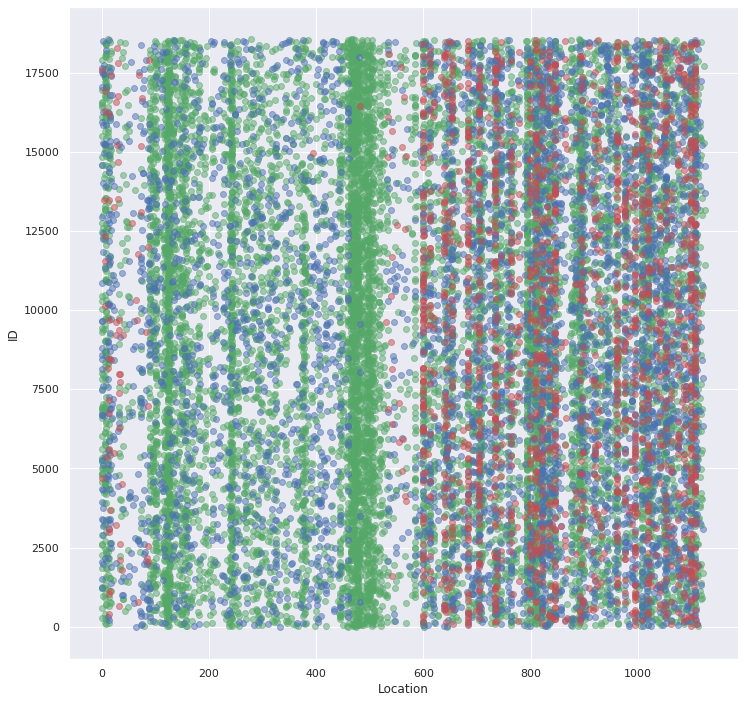

In [9]:
# plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(x = train_test[train_test['fault_severity'].isnull()]['location'], y = train_test[train_test['fault_severity'].isnull()].index,alpha=0.5,color='k',s=2)
ax.scatter(x = train_test[train_test['fault_severity'] == 0]['location'], y = train_test[train_test['fault_severity'] == 0]['id'],alpha=0.5,color='g')
ax.scatter(x = train_test[train_test['fault_severity'] == 1]['location'], y = train_test[train_test['fault_severity'] == 1]['id'],alpha=0.5,color='b')
ax.scatter(x = train_test[train_test['fault_severity'] == 2]['location'], y = train_test[train_test['fault_severity'] == 2]['id'],alpha=0.5,color='r')
ax.set_xlabel('Location')
ax.set_ylabel('ID')

Severity Types 3 and 5 are not common

In [10]:
print('Severity type of fault severity 0 \n {}'.format(train_test[train_test['fault_severity'] == 0]['severity_type'].value_counts(normalize=True)))
print('Severity type of fault severity 1 \n {}'.format(train_test[train_test['fault_severity'] == 1]['severity_type'].value_counts(normalize=True)))
print('Severity type of fault severity 2 \n {}'.format(train_test[train_test['fault_severity'] == 2]['severity_type'].value_counts(normalize=True)))

Severity type of fault severity 0 
 2.0    0.535210
1.0    0.391697
4.0    0.069334
5.0    0.003091
3.0    0.000668
Name: severity_type, dtype: float64
Severity type of fault severity 1 
 1.0    0.598945
2.0    0.357806
4.0    0.037553
5.0    0.005696
Name: severity_type, dtype: float64
Severity type of fault severity 2 
 1.0    0.651820
2.0    0.344378
4.0    0.003259
5.0    0.000543
Name: severity_type, dtype: float64


Label Orange BSs in the bs daataframe with high, medium and low number of fault severities

In [11]:
# Falut Severity 2 - low quality
bs_fault2 = train_test[train_test['fault_severity'] == 2].groupby('location').count()['severity_type'].index

# Falut Severity 1 - medium quality
bs_fault1 = train_test[(train_test['fault_severity'] == 1)].groupby('location').count()['severity_type'].index
bs_fault1 = bs_fault1[~bs_fault1.isin(bs_fault2)]

train_test['bs_quality'] = ''
# Lable Fault Severity 2
train_test.loc[train_test['location'].isin(bs_fault2), 'bs_quality'] = 'low'
# Lable Fault Severity 1
train_test.loc[train_test['location'].isin(bs_fault1), 'bs_quality'] = 'medium'
# Lable Fault Severity 0
train_test.loc[train_test['bs_quality'] == '', 'bs_quality'] = 'good'

train_test.head()

id  location  fault_severity  severity_type bs_quality
0  14121     118.0               1            2.0     medium
1   9320      91.0               0            2.0     medium
2  14394     152.0               1            2.0     medium
3   8218     931.0               1            1.0        low
4  14804     120.0               0            1.0     medium

Add placeholders to the train_test dataframe for all Orange BS

In [24]:
# Total number of Orange BSs
orange_bs_no = bs.shape[0]
# Total number of BSs in the train_test df
df_bs_no = train_test.location.unique().shape[0]

# Range of locations needed
bs_loc_range = range(df_bs_no, orange_bs_no)

# Average number of entries for each location
####mu = train_test.groupby('location').count()['id'].mean()
# STD of the number of entries for each location
####sig = train_test.groupby('location').count()['id'].std()
####number_entry_per_loc = train_test.groupby('location').count()['id']

no_processes = multiprocessing.cpu_count()

# idx = train_test_exd.id.max() + 1

# Add locations in range bs_loc_range with random number of entries for each
def add_placeholder(loc_range):
    df_placeholder = []
    # Starting ID number and Location number
    idx = train_test.id.max() + bs_loc_range[0] 
    for loc in loc_range:
        try:
            rand_entry = random.choice(number_entry_per_loc)
            if rand_entry == 1:
                df_placeholder.append({'id': idx, 'location': loc, 'fault_severity':'', 'severity_type':'', 'bs_quality':''})
                idx += len(loc_range) // no_processes
            else:
                for i in range(1, max(3,rand_entry)):
                    df_placeholder.append({'id': idx, 'location': loc, 'fault_severity':'', 'severity_type':'', 'bs_quality':''})
                    idx += len(loc_range) // no_processes
        except:
            pass
    return pd.DataFrame(df_placeholder)

def add_placeholder_multi_process(bs_loc_range):
    range_len = len(bs_loc_range) // no_processes 
    chunks = [bs_loc_range[i::range_len] for i in range(range_len)]

    with multiprocessing.Pool(processes=no_processes) as pool:
        result = pool.map(add_placeholder, chunks) 
    
    return pd.concat(result)
    
train_test_placeholder = add_placeholder_multi_process(bs_loc_range)    

In [26]:
train_test_placeholder[['fault_severity', 'severity_type']] = train_test_placeholder[['fault_severity', 'severity_type']].apply(pd.to_numeric)
train_test_ext = pd.concat([train_test, train_test_placeholder])

In [ ]:
train_test_ext.to_pickle("./dataframes/train_test_ext_v1.pkl")

Assign BSs locations in the dataset to Orange BSs based on the antenna type of Orange BSs

In [48]:
# list of low quality locations
low_q_bs = train_test_ext.loc[train_test_ext['bs_quality'] == 'low', 'location'].unique()
# list of medium quality locations
medium_q_bs = train_test_ext.loc[train_test_ext['bs_quality'] == 'medium', 'location'].unique()
# list of high quality locationss 
good_q_bs = train_test_ext.loc[train_test_ext['bs_quality'] == 'good', 'location'].unique()

# Lable Orange BSc quality as medium, good, low
# ie. if Orange BS has a SECTOR antenna, there is a higher change it's assigned a location from medium_q_bs
quality_list_n = [0, 1, 2]
quality_list = [list(low_q_bs), list(medium_q_bs), list(good_q_bs)]
def assign_location(df):
    if df == 'SECTOR':
        rand_list_num = random.choice(np.random.choice(quality_list_n, 1, p=[0.25, 0.45, 0.3]))
        try:
            rand_bs_num = random.choice(quality_list[rand_list_num])
            quality_list[rand_list_num].remove(rand_bs_num)
        except:
            return None
        return rand_bs_num
    
    elif df == 'MICROCELL':
        rand_list_num = random.choice(np.random.choice(quality_list_n, 1, p=[0.2, 0.35, 0.45]))
        try:
            rand_bs_num = random.choice(quality_list[rand_list_num])
            quality_list[rand_list_num].remove(rand_bs_num)
        except:
            return None
        return rand_bs_num
    
    elif df == 'OMNI':
        rand_list_num = random.choice(np.random.choice(quality_list_n, 1, p=[0.6, 0.3, 0.1]))
        try:
            rand_bs_num = random.choice(quality_list[rand_list_num])
            quality_list[rand_list_num].remove(rand_bs_num)
        except:
            return None
        return rand_bs_num
    
bs['location'] = bs['Anttype'].apply(assign_location)
uk_bs = bs[~((bs['location'].isnull()))].copy()
uk_bs['location'] = uk_bs['location'].apply(pd.to_numeric)


train_test_loc = train_test_ext.merge(uk_bs, left_on='location', right_on='location').drop(['Operator', 'Maxpwrdbw', 'Maxpwrdbm'], axis=1).dropna()

### Merge all Orange UK BSs

In [49]:
# BSs that do not have a location assigned
bs_available = bs[~((bs['Sitelat'].isin(train_test_loc['Sitelat'])) & (bs['Sitelng'].isin(train_test_loc['Sitelng'])))].copy()
# Locations in Train_Test_Ext that do not have a fault_severity and bs_quality assigned
train_test_available = train_test_ext[train_test_ext['severity_type'].isnull()].copy()

# Assign a Location column equal to the length of the location column in train_test_available
bs_available.loc[:,'location'] = train_test_available.location.unique()[:bs_available.shape[0]]

# Merge the dataframe on location column and append it to the main dataset
train_test_available = train_test_available.merge(bs_available, on='location').drop(['Operator', 'Maxpwrdbw', 'Maxpwrdbm'], axis=1)

#### Imputing missing fault_severity using KNN again to impute ault_severity	severity_type based on location

In [51]:
# Train KNN learner
clf = KNeighborsClassifier(2, weights='distance')
trained_model = clf.fit(train_test_loc.loc[:, ['Sitelng','Sitelat']], train_test_loc.loc[:, ['fault_severity', 'severity_type']])
# trained_model = clf.fit(train_test_sev_loc.loc[:, ['Sitelng','Sitelat','Anttype','Sitengr', 'Opref', 'Transtype', 'Antennaht']], train_sev_log_rs.loc[:, ['fault_severity', 'severity_type']])

train_test_available[['fault_severity','severity_type']] = trained_model.predict(train_test_available.loc[:, ['Sitelng','Sitelat']])
train_test_all = train_test_loc.append(train_test_available)
train_test_all.head()

id  location  fault_severity  severity_type bs_quality    Opref  \
0  14121     118.0             1.0            2.0     medium  AVN0132   
1   6821     118.0             0.0            1.0     medium  AVN0132   
2  12008     118.0             0.0            2.0     medium  AVN0132   
3  18441     118.0             0.0            2.0     medium  AVN0132   
4   9479     118.0             0.0            2.0     medium  AVN0132   

        Sitengr  Antennaht Transtype  Freqband Anttype  Powerdbw    Sitelat  \
0  ST7203064280       15.5      UMTS      2100  SECTOR      27.9  51.376386   
1  ST7203064280       15.5      UMTS      2100  SECTOR      27.9  51.376386   
2  ST7203064280       15.5      UMTS      2100  SECTOR      27.9  51.376386   
3  ST7203064280       15.5      UMTS      2100  SECTOR      27.9  51.376386   
4  ST7203064280       15.5      UMTS      2100  SECTOR      27.9  51.376386   

    Sitelng  
0 -2.401905  
1 -2.401905  
2 -2.401905  
3 -2.401905  
4 -2.401905

### Timestame events in the dataset

In [540]:
# Sort the dataframe based on location and id (ascending)
train_test_time = train_test_all.sort_values(['location', 'id'], ascending=[True, True])

train_test_time['num'] = train_test_time.groupby(['location']).cumcount()+1
# Normalize the count within each location
train_test_time['numsh'] = train_test_time.groupby('location')['num'].apply(lambda x: x / (x.max() + 1))

def str_time_prop(start, end, format, prop):
    """Get a time at a proportion of a range of two formatted times.

    start and end should be strings specifying times formated in the
    given format (strftime-style), giving an interval [start, end].
    prop specifies how a proportion of the interval to be taken after
    start.  The returned time will be in the specified format.
    """

    stime = time.mktime(time.strptime(start, format))
    etime = time.mktime(time.strptime(end, format))

    ptime = stime + prop * (etime - stime)

    return time.strftime(format, time.localtime(ptime))


def random_date(start, end, prop):
    return str_time_prop(start, end, '%d/%m/%Y %I:%M %p', prop)

# Convert numsh column to real time 
train_test_time['time'] = train_test_time.loc[:,'numsh'].apply(lambda x: random_date("01/01/2014 12:00 AM", "01/01/2017 12:00 PM", x))
pd.to_datetime(train_test_time['time'])
train_test_time.head()

id  location  fault_severity  severity_type bs_quality    Opref  \
5825   282       1.0             0.0            2.0        low  ARM0011   
5813   590       1.0             0.0            2.0        low  ARM0011   
5850  1233       1.0             0.0            1.0        low  ARM0011   
5800  1235       1.0             1.0            1.0        low  ARM0011   
5805  1247       1.0             0.0            1.0        low  ARM0011   

           Sitengr  Antennaht Transtype  Freqband Anttype  Powerdbw  \
5825  IJ0508940781       15.0       GSM      1800  SECTOR      27.4   
5813  IJ0508940781       15.0       GSM      1800  SECTOR      27.4   
5850  IJ0508940781       15.0       GSM      1800  SECTOR      27.4   
5800  IJ0508940781       15.0       GSM      1800  SECTOR      27.4   
5805  IJ0508940781       15.0       GSM      1800  SECTOR      27.4   

        Sitelat   Sitelng  num     numsh                 time  
5825  54.304986 -6.386361    1  0.014286  16/01/2014 03:56 PM  
5813  54.304986 -6.386361    2  0.028571  01/02/2014 07:53 AM  
5850  54.304986 -6.386361    3  0.042857  16/02/2014 11:49 PM  
5800  54.304986 -6.386361    4  0.057143  04/03/2014 03:46 PM  
5805  54.304986 -6.386361    5  0.071429  20/03/2014 07:42 AM

In [54]:
train_test_time.to_pickle("./dataframes/train_test_time_v1.pkl")

#### Distribution of BSs accross the UK and their average fault severity (sample size = 1.4%)

In [293]:
sample_df = train_test_time.sample(frac=.014, random_state=1)
# Average fault_severity of each location
fault_severity_mean = sample_df[['location', 'fault_severity', 'Sitelat', 'Sitelng']].groupby('location').mean().reset_index()
fault_severity_mean['marker_color'] = pd.cut(fault_severity_mean['fault_severity'], bins=3, 
                              labels=['green', 'orange', 'red'])

# colors = {'SECTOR': 'blue', 'MICROCELL': 'green', 'OMNI': 'red'}
map_osm = folium.Map(
                     zoom_start=6,
                     location=[fault_severity_mean['Sitelat'].mean(), 
                     fault_severity_mean['Sitelng'].mean()],
                     control_scale=True)

fault_severity_mean.apply(lambda row:folium.CircleMarker(location=[row["Sitelat"], 
                                               row["Sitelng"]], 
                                               fill_color=row['marker_color'], 
                                               fill=True, fill_opacity=0.7, color='r', radius=1.5).add_to(map_osm), axis=1)
map_osm

In [181]:
sample_df = train_test_time.sample(frac=.051, random_state=1)
# Average fault_severity of each location
fault_severity_mean = sample_df[['location', 'fault_severity', 'Sitelat', 'Sitelng']].groupby('location').mean().reset_index()
fault_severity_mean['marker_color'] = pd.cut(fault_severity_mean['fault_severity'], bins=3, 
                              labels=['green', 'orange', 'red'])

# colors = {'SECTOR': 'blue', 'MICROCELL': 'green', 'OMNI': 'red'}
map_osm = folium.Map(
                     zoom_start=6,
                     location=[fault_severity_mean['Sitelat'].mean(), 
                     fault_severity_mean['Sitelng'].mean()],
                     control_scale=True)

mc = MarkerCluster()
fault_severity_mean.apply(lambda row:folium.Marker(location=[row["Sitelat"], 
                                               row["Sitelng"]]).add_to(mc), axis=1)

map_osm.add_child(mc)
map_osm

In [332]:
# train_test_sev_loc_time[train_test_sev_loc_time['location'].isin(range(2000))].plot(x='time', y='fault_severity', kind='kde', bw_method=.1)

## EDA

#### 1. Timeseries Analysis

In [541]:
# Set the time column as index and sort it
df_timeseries = train_test_time.set_index(pd.DatetimeIndex(train_test_time['time'])).sort_index()

In [508]:
# df_timeseries = df_timeseries.loc['2014-1-1':'2017-02-10']

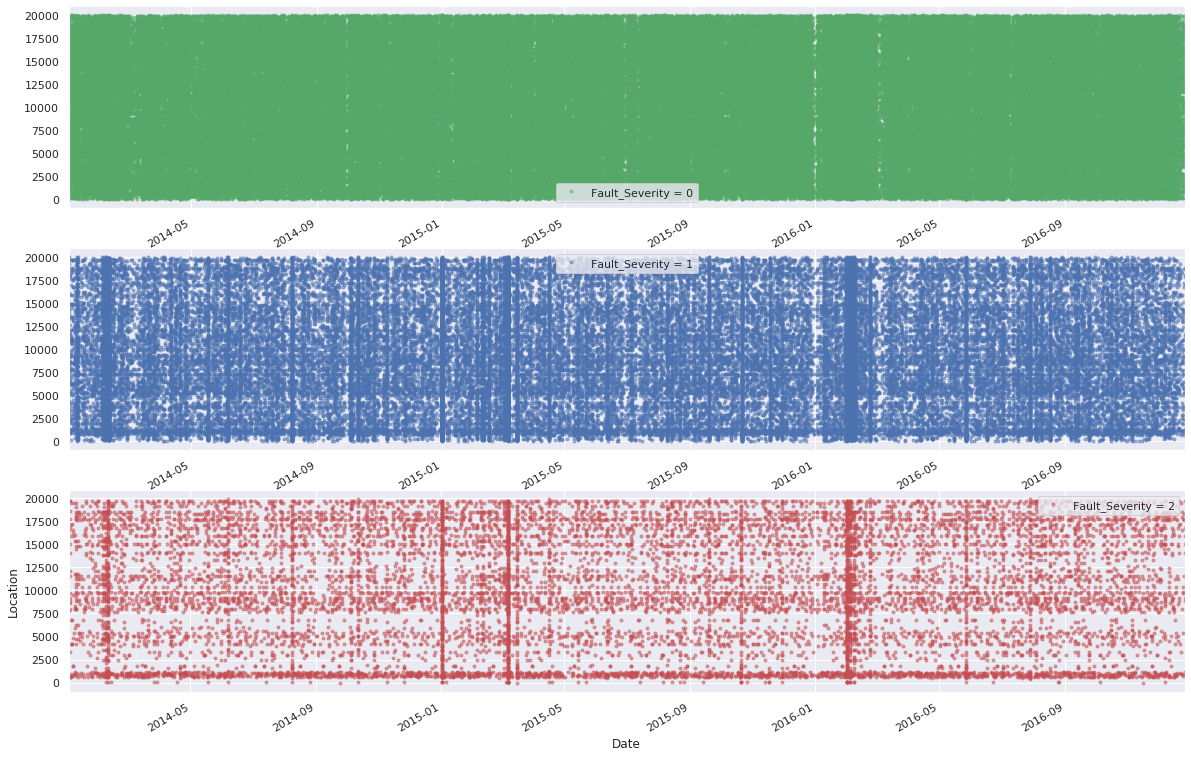

In [542]:
fig, axes = plt.subplots(3,1, figsize=(20, 14))

df_timeseries[df_timeseries['fault_severity'] == 0]['location'].plot(marker='.', color='g', alpha=0.5, linestyle='None', figsize=(20, 14), ax=axes[0], label='Fault_Severity = 0')
df_timeseries[df_timeseries['fault_severity'] == 1]['location'].plot(marker='.', color='b', alpha=0.5, linestyle='None', figsize=(20, 14), ax=axes[1], label='Fault_Severity = 1')
df_timeseries[df_timeseries['fault_severity'] == 2]['location'].plot(marker='.', color='r', alpha=0.5, linestyle='None', figsize=(20, 14), ax=axes[2], label='Fault_Severity = 2')
plt.xlabel('Date')
plt.ylabel('Location')

for i in range(3):
    axes[i].legend()

Monthly sum resample of fault_severity

(735234.0, 736288.0)

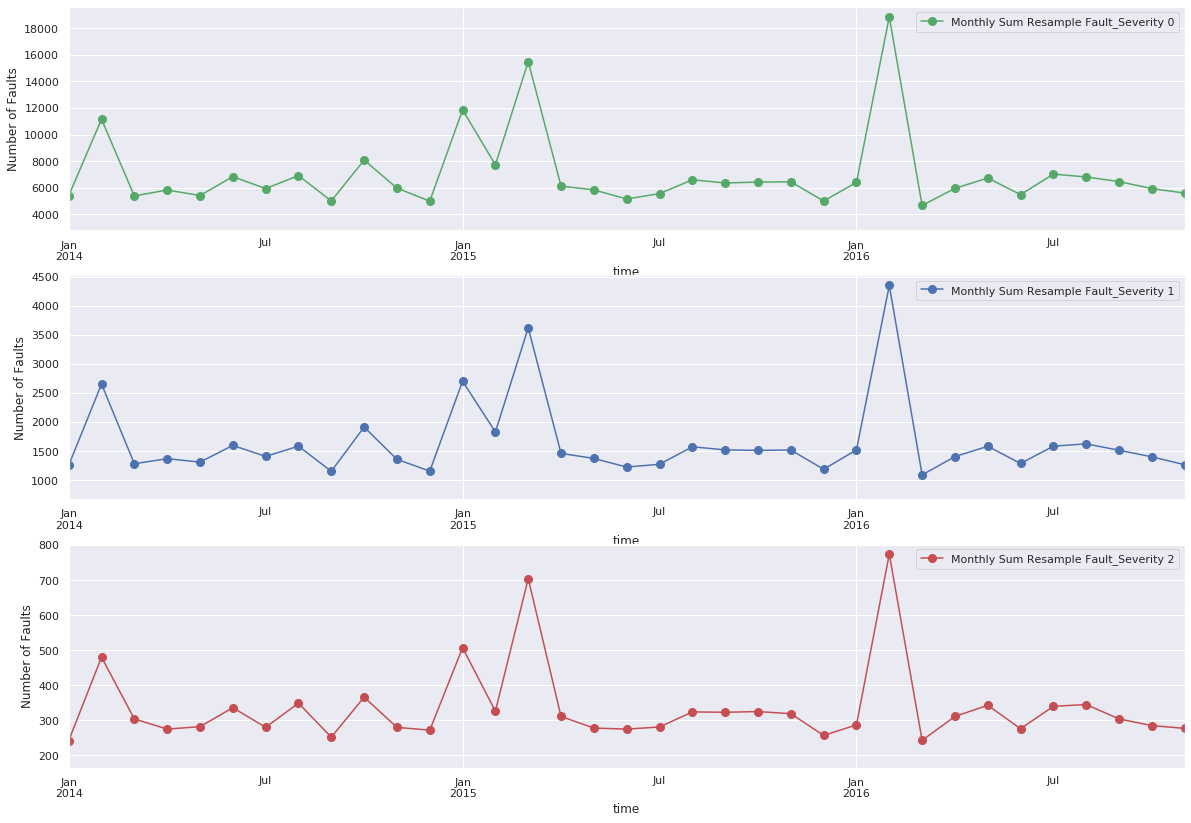

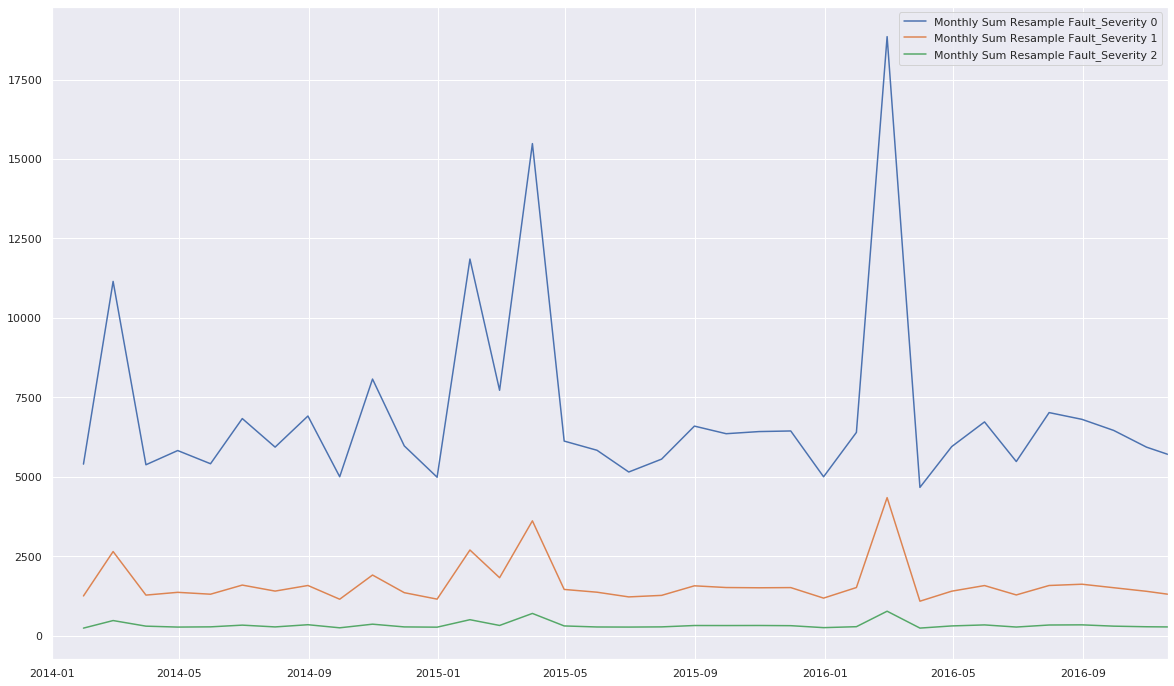

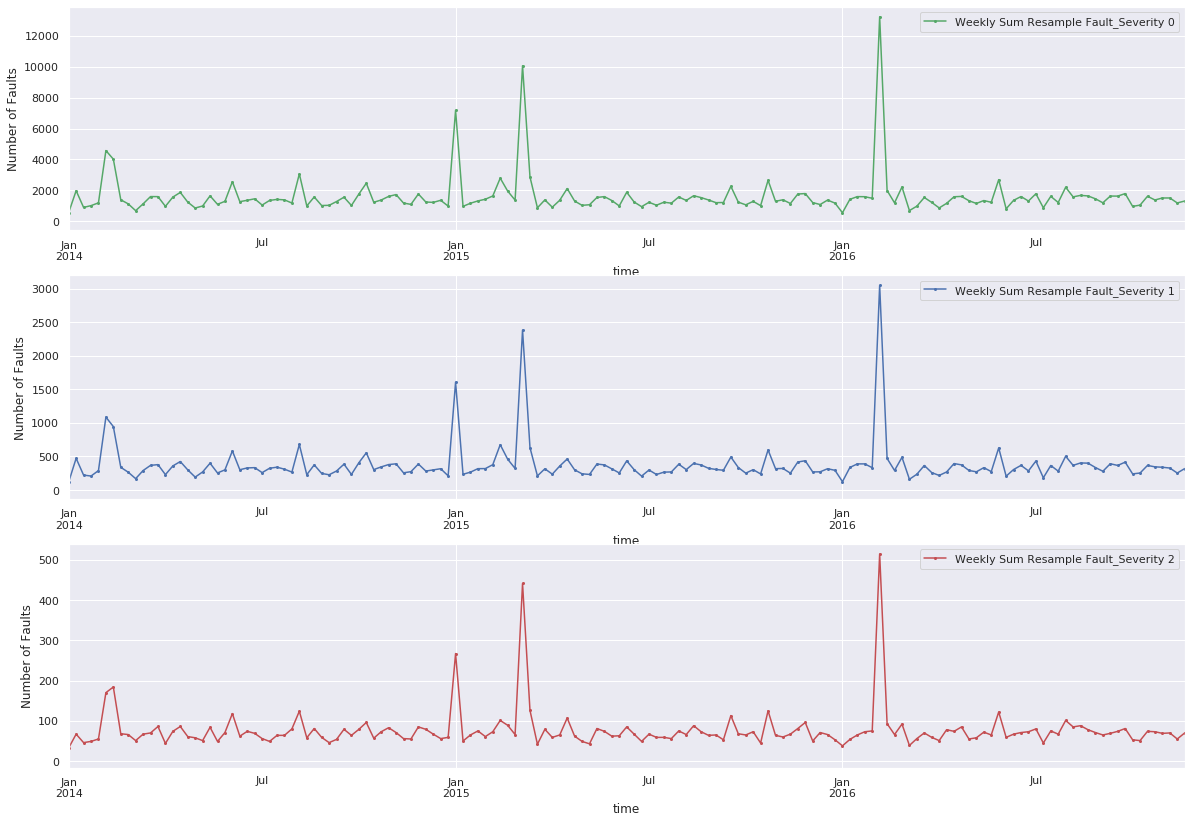

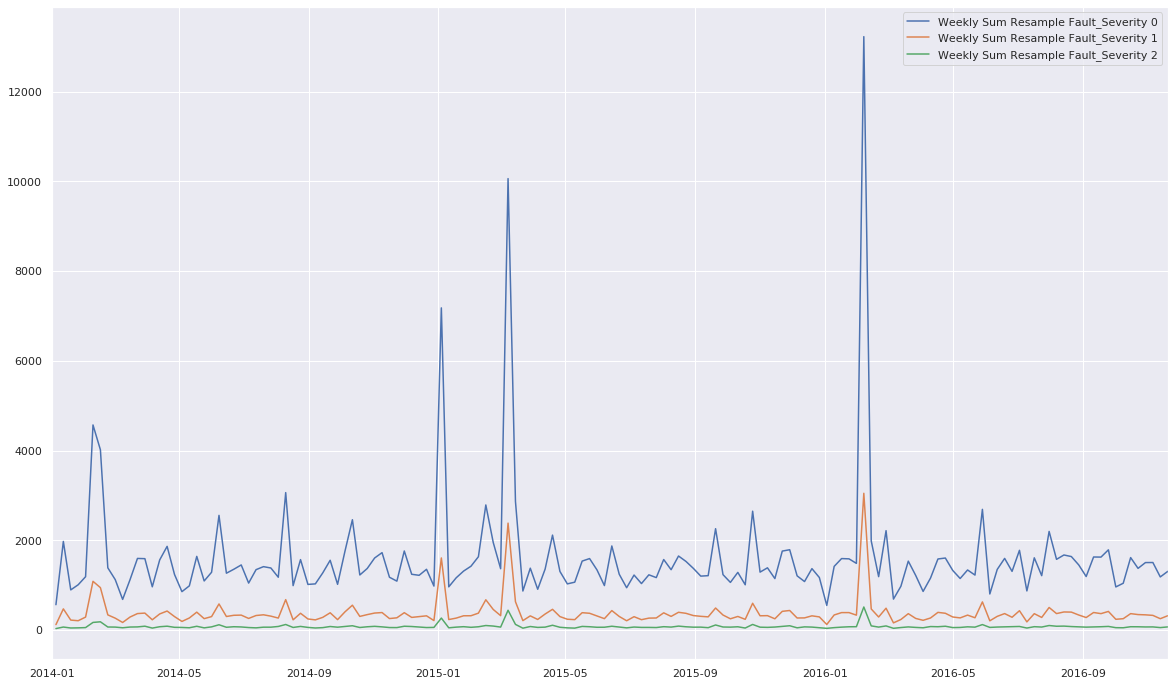

In [551]:
def sum_monthly(fault_sev):
    df = df_timeseries[df_timeseries['fault_severity'] == fault_sev]['fault_severity'].copy()
    df[:] = 1
    return df.resample('M').sum()

fig1, ax1 = plt.subplots(3,1, figsize=(20, 14))
sum_monthly(0).plot(marker='o', markersize=8, linestyle='-', color='g',
            label='Monthly Sum Resample Fault_Severity {}'.format(0), figsize=(20, 14), ax=ax1[0])
sum_monthly(1).plot(marker='o', markersize=8, linestyle='-', color='b',
            label='Monthly Sum Resample Fault_Severity {}'.format(1), figsize=(20, 14), ax=ax1[1])
sum_monthly(2).plot(marker='o', markersize=8, linestyle='-', color='r',
            label='Monthly Sum Resample Fault_Severity {}'.format(2), figsize=(20, 14), ax=ax1[2])
for i in range(3):
    ax1[i].set_ylabel('Number of Faults')
    ax1[i].legend()
    ax1[i].set_xlim('2014','2016-11-20')

fig2, ax2 = plt.subplots(figsize=(20, 12))
for i in range(3):
    ax2.plot(sum_monthly(i), linestyle='-', label='Monthly Sum Resample Fault_Severity {}'.format(i)) 
ax2.legend()
ax2.set_xlim('2014','2016-11-20')


def sum_weekly(fault_sev):
    df = df_timeseries[df_timeseries['fault_severity'] == fault_sev]['fault_severity'].copy()
    df[:] = 1
    return df.resample('W').sum()

fig3, ax3 = plt.subplots(3,1, figsize=(20, 14))
sum_weekly(0).plot(marker='o', markersize=2, linestyle='-', color='g',
            label='Weekly Sum Resample Fault_Severity {}'.format(0), figsize=(20, 14), ax=ax3[0])
sum_weekly(1).plot(marker='o', markersize=2, linestyle='-', color='b',
            label='Weekly Sum Resample Fault_Severity {}'.format(1), figsize=(20, 14), ax=ax3[1])
sum_weekly(2).plot(marker='o', markersize=2, linestyle='-', color='r',
            label='Weekly Sum Resample Fault_Severity {}'.format(2), figsize=(20, 14), ax=ax3[2])
for i in range(3):
    ax3[i].set_ylabel('Number of Faults')
    ax3[i].legend()
    ax3[i].set_xlim('2014','2016-11-20')

fig4, ax4 = plt.subplots(figsize=(20, 12))
for i in range(3):
    ax4.plot(sum_weekly(i), linestyle='-', label='Weekly Sum Resample Fault_Severity {}'.format(i)) 
ax4.legend()
ax4.set_xlim('2014','2016-11-20')


##### Number of Weekly severity_type

(735234.0, 736288.0)

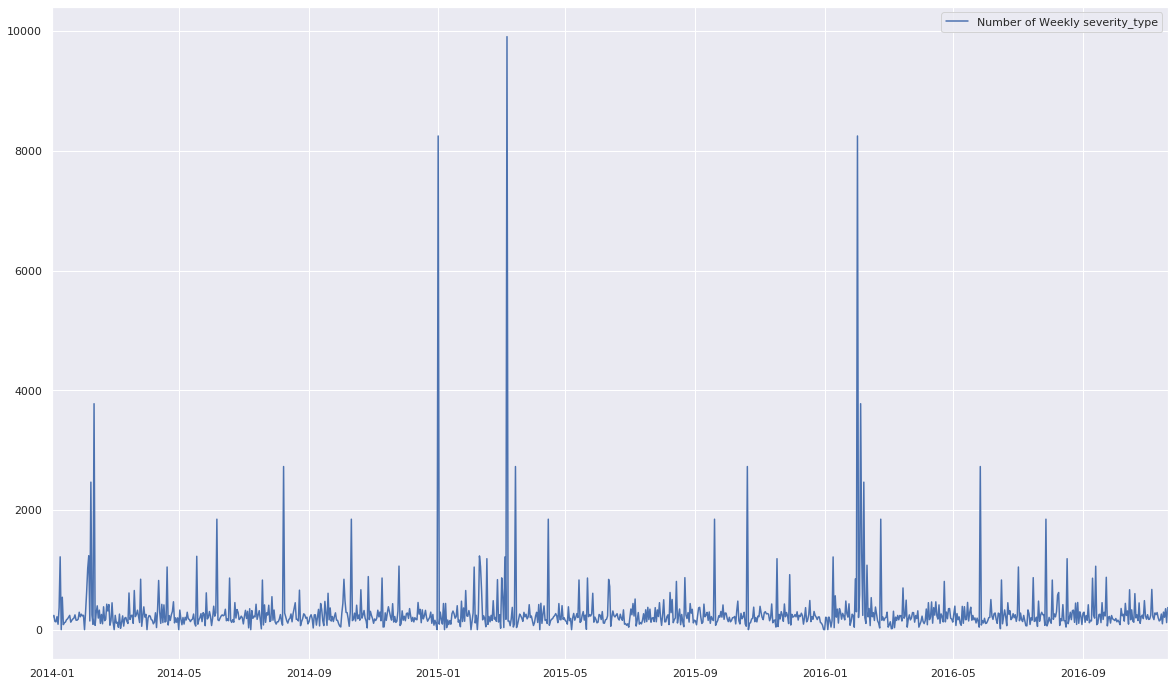

In [564]:
def sum_weekly():
    df = df_timeseries['severity_type'].copy()
    df[:] = 1
    return df.resample('D').sum()

fig1, ax1 = plt.subplots(figsize=(20, 12))
# for i in range(1,6):
ax1.plot(sum_weekly(), linestyle='-', label='Number of Weekly severity_type') 
ax1.legend()
ax1.set_xlim('2014','2016-11-20')

#### Weekly Faults of 5 Locations with the Highest Number of Faults

In [721]:
top_5 = df_timeseries.groupby('location').count()['id'].sort_values(ascending=False).index[:4].to_list()
bottom_5 = df_timeseries.groupby('location').count()['id'].sort_values(ascending=True).index[10000:10005].to_list()

In [ ]:
weekly_fault_location = df_timeseries.groupby('location').resample('M').count()

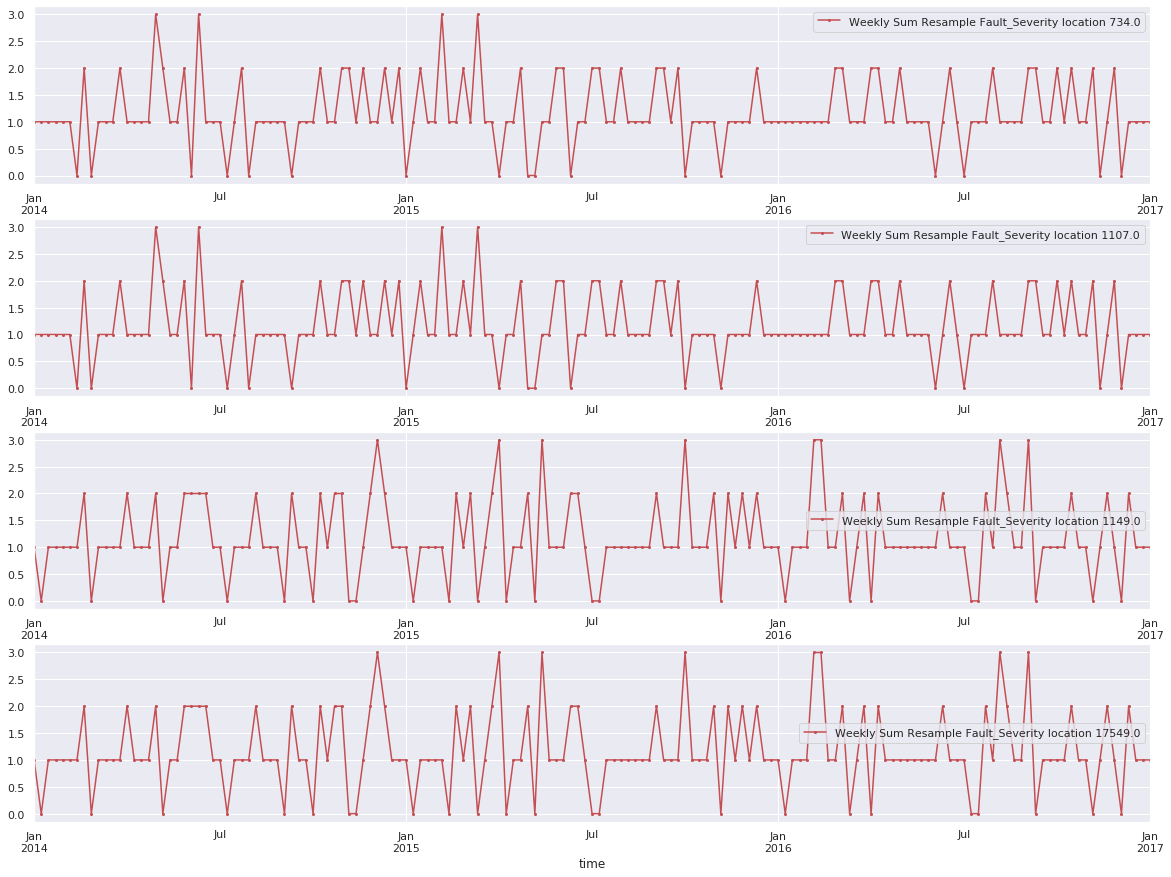

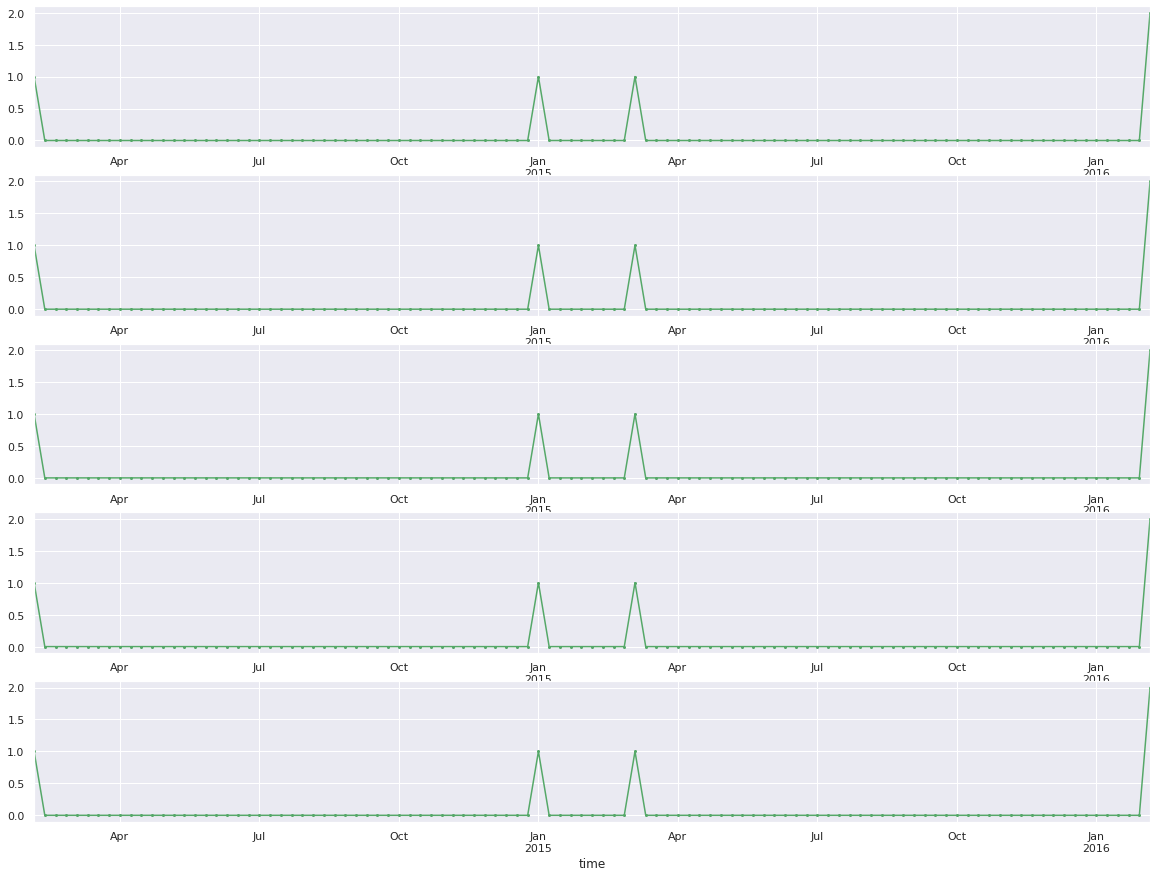

In [722]:
fig1, ax1 = plt.subplots(4,1, figsize=(20, 15))
for i, j in enumerate(top_5):
    weekly_fault_location.loc[top_5[i], 'fault_severity'].plot(marker='o', markersize=2, linestyle='-', color='r',
                label='Weekly Sum Resample Fault_Severity location {}'.format(top_5[i]), ax=ax1[i])
    ax1[i].legend()

fig2, ax2 = plt.subplots(5,1, figsize=(20, 15))
for i, j in enumerate(bottom_5):
    weekly_fault_location.loc[bottom_5[i], 'fault_severity'].plot(marker='o', markersize=2, linestyle='-', color='g',
                label='Weekly Sum Resample Fault_Severity {}'.format(bottom_5[i]), ax=ax2[i])

In [547]:
# Feature engineer the time coloumn
train_test_time['time'] = pd.to_datetime(train_test_time['time'])
# def f(df):
#     df = df.copy()
#     df['Year'] = DatetimeIndex(df['Date']).year
#     df['Month'] = DatetimeIndex(df['Date']).month
#     df['Day'] = DatetimeIndex(df['Date']).day
#     return df

# Extract year, month, day and hour from the time column
train_test_time['year'] = train_test_time['time'].dt.year
train_test_time['month'] = train_test_time['time'].dt.month
train_test_time['day'] = train_test_time['time'].dt.day
train_test_time['week_of_month'] = train_test_time['day'].apply(lambda d: (d-1) // 7 + 1)
train_test_time['hour'] = train_test_time['time'].dt.hour

train_test_dmy = train_test_time.drop(['id','bs_quality', 'num', 'numsh', 'time', 'location', 'Opref'], axis=1)

In [376]:
def cut_values(df,col,bins,labels):
    return pd.cut(df[col], bins=bins, labels=labels)

# Cut values to categories
def process_time(df):
    b_time = [-1,4,8,12,16,20,25]
    l_time = ['late night', 'early morning','morning','noon','eve','night']
    df['part_of_day'] = cut_values(df, 'hour', b_time, l_time)
    return df.drop(["hour"],axis=1)

def process_freq(df):
    b_freq = [1700, 1850, 2000, 2200]
    l_freq = ['low', 'medium','high']
#     df["Freqband"] = df["Freqband"].fillna(df["Freqband"].mean())
    df['freq_band'] = cut_values(df, 'Freqband', b_freq, l_freq)
#     df["freq_band"].dropna(inplace=True)
    return df.drop(["Freqband"],axis=1)

def process_antenna(df):
    b_antenna = [-1, 12, 25,  40, 75, 200]
    l_antenna = ['vary short', 'short', 'medium','long', 'very long']
    df['antenna_ht'] = cut_values(df, 'Antennaht', b_antenna, l_antenna)
    return df.drop(["Antennaht"],axis=1)

def process_power(df):
    b_power = [-20, 9, 18, 25, 29, 40]
    l_power = ['vary low', 'low', 'medium','high', 'very high']
    df['power_db'] = cut_values(df, 'Powerdbw', b_power, l_power)
    return df.drop(["Powerdbw"],axis=1)

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name, drop_first=True)
    df = pd.concat([df,dummies],axis=1)
    return df.drop([column_name],axis=1)

In [377]:
def pre_process(df):
    df = process_time(df)
    df = process_freq(df)
    df = process_antenna(df)
    df = process_power(df)

    for col in ['severity_type','antenna_ht',
                'Transtype','Anttype','power_db',
                'year','month','day', 'week_of_month', 'part_of_day','freq_band']:
        df = create_dummies(df,col)
    return df

train_df = pre_process(train_test_dmy)

In [388]:
train_df.columns

Index(['fault_severity', 'Sitengr', 'Sitelat', 'Sitelng', 'severity_type_2.0',
       'severity_type_3.0', 'severity_type_4.0', 'severity_type_5.0',
       'antenna_ht_short', 'antenna_ht_medium', 'antenna_ht_long',
       'antenna_ht_very long', 'Transtype_UMTS', 'Anttype_OMNI',
       'Anttype_Pico', 'Anttype_SECTOR', 'power_db_low', 'power_db_medium',
       'power_db_high', 'power_db_very high', 'year_2016', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'day_2', 'day_3',
       'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10',
       'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17',
       'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24',
       'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31',
       'week_of_month_2', 'week_of_month_3', 'week_of_month_4',
       'week_of_month_5', 'part_of_day_early morning', 'part_o

In [379]:
def select_features(df):
    # Remove non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(['fault_severity'],axis=1)
    all_y = df['fault_severity']
    
    clf = RandomForestClassifier(random_state=1, n_jobs=-1)
    selector = RFECV(clf,cv=10, n_jobs=-1)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

feature_cols = select_features(train_df)

Best Columns 
------------
['Sitelat', 'Sitelng', 'severity_type_2.0']



In [383]:
train_df.Sitengr.unique().shape

(12706,)

In [345]:
feature_cols = ['Sitelat', 'Sitelng',
                'severity_type_2.0', 'severity_type_3.0', 'severity_type_4.0','severity_type_5.0',
                'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
                'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 
                'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 
                'day_9', 'day_10','day_11', 'day_12', 'day_13', 'day_14', 'day_15', 
                'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 
                'day_23', 'day_24','day_25', 'day_26', 'day_27', 'day_28', 'day_29', 
                'day_30', 'day_31',
                'part_of_day_early morning', 'part_of_day_morning', 'part_of_day_noon','part_of_day_eve', 'part_of_day_night']

In [346]:
dataset = train_df.drop("fault_severity",axis=1)
labels = train_df["fault_severity"]
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)
#         {
#             "name": "KNeighborsClassifier",
#             "estimator": KNeighborsClassifier(n_jobs=-1),
#             "hyperparameters":
#                 {
#                     "n_neighbors": range(1,10,4),
#                     "weights": ["distance", "uniform"],
#                     "algorithm": ["ball_tree", "kd_tree", "brute"],
#                     "p": [1,2]
#                 }
#         }, 
#         {
#             "name": "XGBClassifier",
#             "estimator": XGBClassifier(),
#             "hyperparameters":
#                 {
#                 "learning_rate": [0.02, 0.03], 
#                 "n_estimators": [600, 1000],
#                 "objective": ["multi:softmax"],
#                 "verbosity": [2]
#                 }
#         },X_train, X_test, y_train, y_test = train_test_split(tr, ts, test_size=0.2, random_state=42)


#                     "solver": ["newton-cg", "lbfgs", "liblinear"]

In [349]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier

def select_model(df,features):
    
    all_X = df[features]
    all_y = y_train
    cores=multiprocessing.cpu_count()-2
    n_estimators = 10

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "SVM",
            "estimator": OneVsRestClassifier(BaggingClassifier(svm.SVC(probability=True), max_samples=1.0 / n_estimators, n_estimators=n_estimators, n_jobs=-1), n_jobs=-1),
            "hyperparameters":
                {
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1, n_jobs=-1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5],
                }
        },
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg"]
                }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

result = select_model(X_train,feature_cols)

SVM
---


KeyboardInterrupt: 

In [1097]:
# final_train_test.location = final_train_test.location.astype('category')
# final_train_test['part_of_day']


In [843]:
labels = list(final_train_test.columns)
labels.remove('fault_severity')

In [792]:
# Convert categorical columns to numerical
def convert_cat_num(df, col):
    return df[col].astype('category')

obj_num_cols = list(final_train_test.dtypes[~((final_train_test.dtypes == 'category') | (final_train_test.dtypes == 'datetime64[ns]'))].index)
cat_cols = list(final_train_test.dtypes[final_train_test.dtypes == 'category'].index)

# for col in obj_num_cols:
#     final_train_test[col] = convert_cat_num(final_train_test, col)
    
for col in cat_cols:
    final_train_test[col] = convert_obj_num(final_train_test, col)

In [1152]:
train_test_sev.pivot_table(index='fault_severity', columns='severity_type', aggfunc='count')['bs_quality']

severity_type      1.0     2.0  3.0    4.0   5.0
fault_severity                                  
0               4689.0  6407.0  8.0  830.0  37.0
1               2839.0  1696.0  NaN  178.0  27.0
2               1200.0   634.0  NaN    6.0   1.0